<a href="https://colab.research.google.com/github/IsabellaLu519/uoft_APS360_labs/blob/main/Lab5_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Understand batching for a recurrent neural network, and develop custom Dataset and DataLoaders with collate_fn to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link: [My colab link](https://drive.google.com/file/d/1x61hizCN9qve2iZIGa-LYK5coV7iJzyW/view?usp=sharing)

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload SMSSpamCollection

Saving SMSSpamCollection to SMSSpamCollection


In [ ]:
print_ham = False
print_spam = False
for line in open('SMSSpamCollection'):
    if int(print_spam)*int(print_ham) ==1:
        break
    message = line.split("\t",1)
    if message[0] == "ham" and not print_ham:
        print_ham = True

        print("example of non-spam SMS:\n{}".format(message[1]))
    elif message[0] == "spam" and not print_spam:
        print_spam = True

        print("example of spam SMS:\n{}".format(message[1]))

example of non-spam SMS:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

example of spam SMS:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
# Count spam and ham messages
spam_count = 0
ham_count = 0
for line in open('SMSSpamCollection'):
    label = line.split('\t')[0]
    if label == 'spam':
        spam_count += 1
    elif label == 'ham':
        ham_count += 1

print(f"Number of spam messages: {spam_count}")
print(f"Number of non-spam messages: {ham_count}")

Number of spam messages: 747
Number of non-spam messages: 4827


### Part (c) [4 pt]

load and parse the data into two lists: sequences and labels. Create character-level stoi and itos dictionaries. Reserve the index 0 for padding. Convert the sequences to list of character ids using stoi dictionary and convert the labels to a list of 0s and 1s by assinging class "ham" to 0 and class "spam" to 1.

In [ ]:
# Load and parse data
sequences = []
labels = []
with open('SMSSpamCollection', 'r') as file:
    for line in file:
        label, text = line.strip().split('\t', 1)
        sequences.append(text)
        labels.append(1 if label == 'spam' else 0)

# Create character-level stoi and itos dictionaries
chars = sorted(set(''.join(sequences)))
stoi = {char: idx + 1 for idx, char in enumerate(chars)}  # Index 0 reserved for padding
stoi['<pad>'] = 0
itos = {idx: char for char, idx in stoi.items()}

# Convert sequences to list of character indices
sequences_ids = [[stoi[char] for char in seq] for seq in sequences]

print(f"Number of sequences: {len(sequences_ids)}")
print(f"Number of labels: {len(labels)}")
print(f"First sequence (as indices): {sequences_ids[0][:10]}")  # Print first 10 indices of first sequence
print(f"First label: {labels[0]}")
print(f"Vocabulary size: {len(stoi)}")

Number of sequences: 5574
Number of labels: 5574
First sequence (as indices): [40, 79, 1, 85, 78, 84, 73, 76, 1, 74]
First label: 0
Vocabulary size: 117


### Part (d) [4 pt]

Use train_test_split function from sklearn (https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) to split the data indices into `train`, `valid`, and `test`. Use a 60-20-20 split.

You saw in part (b) that there are many more non-spam messages than spam messages. This **imbalance** in our training data will be problematic for training. We can fix this disparity by duplicating spam messages in the training set, so that the training set is roughly balanced.

In [ ]:
from sklearn.model_selection import train_test_split

# Create indices
indices = list(range(len(sequences_ids)))

# Split into train (60%) and temp (40%)
train_idx, temp_idx = train_test_split(indices, test_size=0.4, random_state=42, stratify=labels)

# Split temp into validation (20%) and test (20%)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42,
                                     stratify=[labels[i] for i in temp_idx])

# Create train, validation, and test sets
train_x = [sequences_ids[i] for i in train_idx]
train_y = [labels[i] for i in train_idx]
val_x = [sequences_ids[i] for i in val_idx]
val_y = [labels[i] for i in val_idx]
test_x = [sequences_ids[i] for i in test_idx]
test_y = [labels[i] for i in test_idx]

# Balance the training set
train_spam = []
for idx, item in enumerate(train_x):
    if train_y[idx] == 1:
        train_spam.append(item)
train_x += train_spam * 6
train_y += [1] * (len(train_spam) * 6)

# Print sizes and spam counts
print(f"Training set size: {len(train_x)}")
print(f"Validation set size: {len(val_x)}")
print(f"Test set size: {len(test_x)}")
print(f"Spam messages in training set after balancing: {sum(1 for y in train_y if y == 1)}")
print(f"Ham messages in training set: {sum(1 for y in train_y if y == 0)}")

Training set size: 6032
Validation set size: 1115
Test set size: 1115
Spam messages in training set after balancing: 3136
Ham messages in training set: 2896


### Part (e) [4 pt]

Since each sequence has a different length, we cannot use the default DataLoader. We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) to pad the sequences within the batch to the same size.

We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.

Hint:
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

# Step 1: Load and process data
with open("SMSSpamCollection", 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Build vocab
vocab = sorted(set(''.join([line.split('\t')[1] for line in lines])))
stoi = {ch: i + 1 for i, ch in enumerate(vocab)}  # 0 reserved for padding
itos = {i: ch for ch, i in stoi.items()}

# Step 2: Encode and clean dataset
sequences = []
labels = []
for line in lines:
    label, text = line.strip().split('\t')
    encoded = [stoi[c] for c in text if c in stoi]
    if len(encoded) == 0:  # Skip empty
        continue
    sequences.append(torch.tensor(encoded, dtype=torch.long))
    labels.append(1 if label == 'spam' else 0)

# Step 3: Train-val-test split
train_x, test_x, train_y, test_y = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)  # 10% of train

# Step 4: Dataset class
class MyDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Step 5: Collate function
def collate_sequences(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(t) for t in texts], dtype=torch.long)
    padded = pad_sequence(texts, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return padded, labels, lengths

# Step 6: Dataloaders
train_loader = DataLoader(MyDataset(train_x, train_y), batch_size=32, shuffle=True, collate_fn=collate_sequences)
val_loader = DataLoader(MyDataset(val_x, val_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)
test_loader = DataLoader(MyDataset(test_x, test_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)

# Verify a batch
for batch_x, batch_y, lengths in train_loader:
    print(f"Batch sequences shape: {batch_x.shape}, Batch labels shape: {batch_y.shape}, Lengths: {lengths.shape}")
    break


Batch sequences shape: torch.Size([32, 159]), Batch labels shape: torch.Size([32]), Lengths: torch.Size([32])


### Part (f) [1 pt]

Take a look at 10 batches in `train_loader`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
batch_count = 0
for batch in train_loader:
    if batch_count >= 10:
        break
    batch_x, batch_y, lengths = batch

    max_len = batch_x.shape[1]
    pad_count = torch.sum(batch_x == 0).item()

    print(f"Batch {batch_count + 1}: Maximum sequence length = {max_len}, Number of <pad> tokens = {pad_count}")
    batch_count += 1


Batch 1: Maximum sequence length = 185, Number of <pad> tokens = 3653
Batch 2: Maximum sequence length = 173, Number of <pad> tokens = 3083
Batch 3: Maximum sequence length = 160, Number of <pad> tokens = 2882
Batch 4: Maximum sequence length = 226, Number of <pad> tokens = 4403
Batch 5: Maximum sequence length = 183, Number of <pad> tokens = 2934
Batch 6: Maximum sequence length = 240, Number of <pad> tokens = 4589
Batch 7: Maximum sequence length = 910, Number of <pad> tokens = 26035
Batch 8: Maximum sequence length = 185, Number of <pad> tokens = 3146
Batch 9: Maximum sequence length = 236, Number of <pad> tokens = 4502
Batch 10: Maximum sequence length = 166, Number of <pad> tokens = 3121


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_size, padding_idx=0)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        x = self.embedding(x)  # (batch, seq_len, embed)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.rnn(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)

        last_indices = (lengths - 1).to(x.device)
        batch_size = x.size(0)
        last_outputs = out[torch.arange(batch_size), last_indices]

        return self.fc(last_outputs)


## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    correct, total = 0, 0
    for sms, labels in iter:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, device, epochs=10, lr=0.001):
    import matplotlib.pyplot as plt
    import torch.nn as nn
    import torch

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y, lengths in train_loader:
            x, y, lengths = x.to(device), y.to(device), lengths.to(device)
            optimizer.zero_grad()
            out = model(x, lengths)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (torch.argmax(out, dim=1) == y).sum().item()
            total += y.size(0)
        train_loss.append(total_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation
        model.eval()
        val_total_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for x, y, lengths in val_loader:
                x, y, lengths = x.to(device), y.to(device), lengths.to(device)
                out = model(x, lengths)
                val_total_loss += criterion(out, y).item()
                val_correct += (torch.argmax(out, dim=1) == y).sum().item()
                val_total += y.size(0)
        val_loss.append(val_total_loss / len(val_loader))
        val_acc.append(val_correct / val_total)

        print(f"Epoch {epoch+1}: "
              f"Train Acc={train_acc[-1]:.4f}, Train Loss={train_loss[-1]:.4f}, "
              f"Val Acc={val_acc[-1]:.4f}, Val Loss={val_loss[-1]:.4f}")

    # Plot Accuracy
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Loss
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Final test
    model.eval()
    test_correct, test_total, test_loss_total = 0, 0, 0
    with torch.no_grad():
        for x, y, lengths in test_loader:
            x, y, lengths = x.to(device), y.to(device), lengths.to(device)
            out = model(x, lengths)
            test_loss_total += criterion(out, y).item()
            test_correct += (torch.argmax(out, dim=1) == y).sum().item()
            test_total += y.size(0)

    final_test_acc = test_correct / test_total
    final_test_loss = test_loss_total / len(test_loader)

    print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")
    print(f"Final Test Loss: {final_test_loss:.4f}")

    return model, (train_acc, val_acc), (train_loss, val_loss), (final_test_acc, final_test_loss)


Epoch 1: Train Acc=0.9252, Train Loss=0.2324, Val Acc=0.9596, Val Loss=0.1411
Epoch 2: Train Acc=0.9726, Train Loss=0.1049, Val Acc=0.9686, Val Loss=0.1214
Epoch 3: Train Acc=0.9776, Train Loss=0.0889, Val Acc=0.9709, Val Loss=0.1166
Epoch 4: Train Acc=0.9733, Train Loss=0.0979, Val Acc=0.9641, Val Loss=0.1653
Epoch 5: Train Acc=0.9791, Train Loss=0.0816, Val Acc=0.9619, Val Loss=0.1396
Epoch 6: Train Acc=0.9813, Train Loss=0.0709, Val Acc=0.9664, Val Loss=0.1423


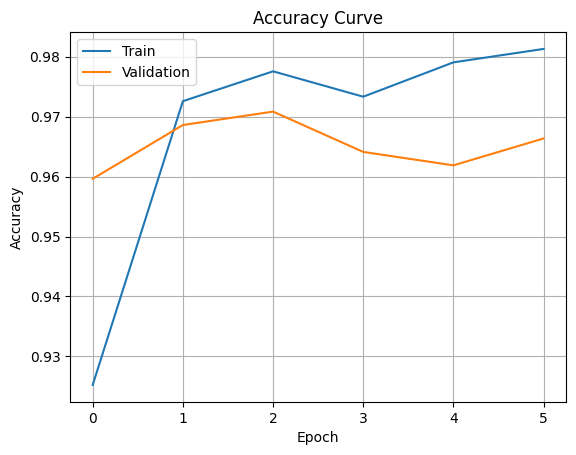

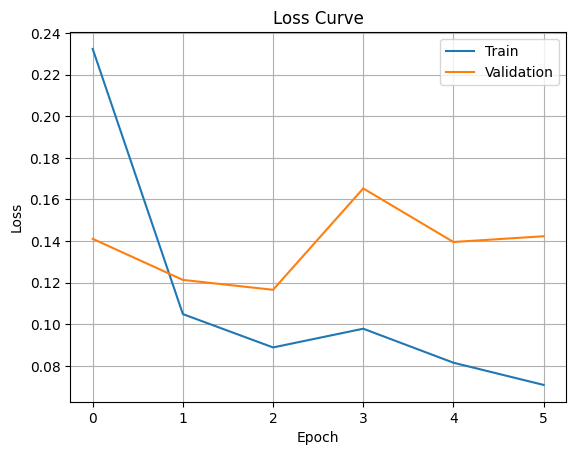


Final Test Accuracy: 0.9776
Final Test Loss: 0.0980


In [ ]:
model = CharRNN(vocab_size=len(stoi), embed_size=64, hidden_size=128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model, (train_acc, val_acc), (train_loss, val_loss), (test_acc, test_loss) = train_and_evaluate_model(
    model, train_loader, val_loader, test_loader, device, epochs=6, lr=0.001)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1: Train Acc=0.9322, Train Loss=0.2028, Val Acc=0.9709, Val Loss=0.1230
Epoch 2: Train Acc=0.9756, Train Loss=0.0996, Val Acc=0.9731, Val Loss=0.1050
Epoch 3: Train Acc=0.9788, Train Loss=0.0835, Val Acc=0.9753, Val Loss=0.1032
Epoch 4: Train Acc=0.9706, Train Loss=0.0928, Val Acc=0.9753, Val Loss=0.0972
Epoch 5: Train Acc=0.9853, Train Loss=0.0617, Val Acc=0.9753, Val Loss=0.0980
Epoch 6: Train Acc=0.9858, Train Loss=0.0542, Val Acc=0.9798, Val Loss=0.0952


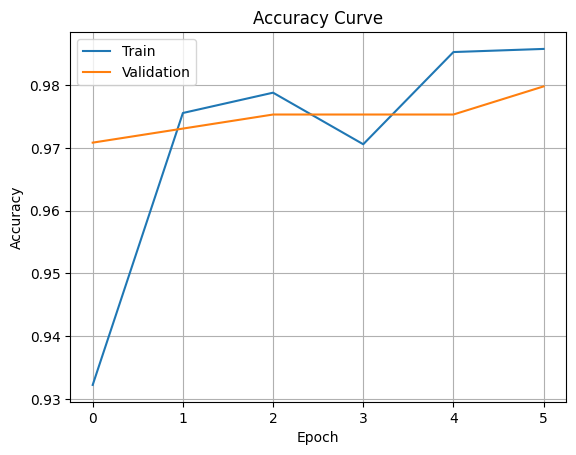

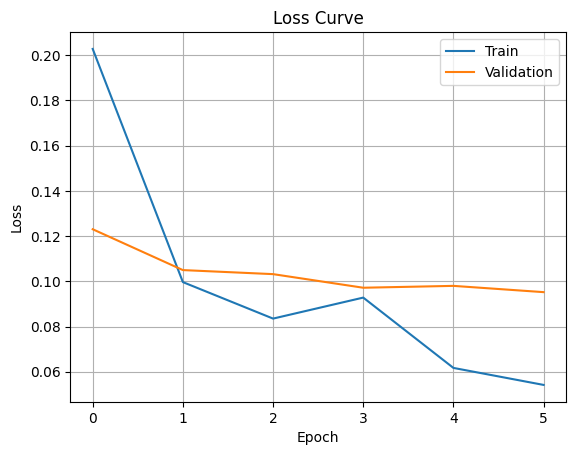


Final Test Accuracy: 0.9785
Final Test Loss: 0.1028


In [ ]:
# change embed_size
model = CharRNN(vocab_size=len(stoi), embed_size=128, hidden_size=128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model, (train_acc, val_acc), (train_loss, val_loss), (test_acc, test_loss) = train_and_evaluate_model(
    model, train_loader, val_loader, test_loader, device, epochs=6, lr=0.001)


Epoch 1: Train Acc=0.9080, Train Loss=0.2550, Val Acc=0.9081, Val Loss=0.3305
Epoch 2: Train Acc=0.9569, Train Loss=0.1470, Val Acc=0.9641, Val Loss=0.1366
Epoch 3: Train Acc=0.9733, Train Loss=0.1028, Val Acc=0.9686, Val Loss=0.1212
Epoch 4: Train Acc=0.9758, Train Loss=0.0922, Val Acc=0.9709, Val Loss=0.1135
Epoch 5: Train Acc=0.9776, Train Loss=0.0846, Val Acc=0.9731, Val Loss=0.1073
Epoch 6: Train Acc=0.9778, Train Loss=0.0850, Val Acc=0.9641, Val Loss=0.1332


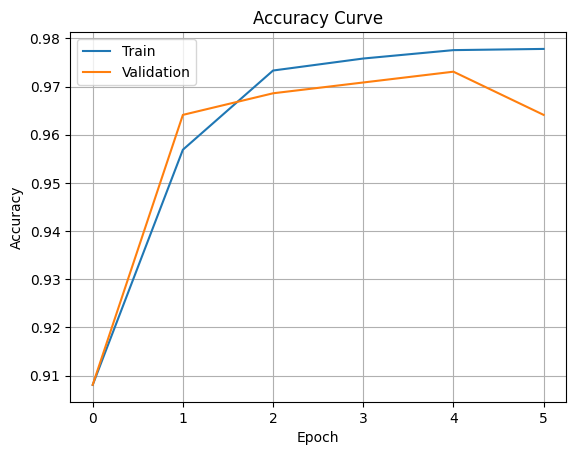

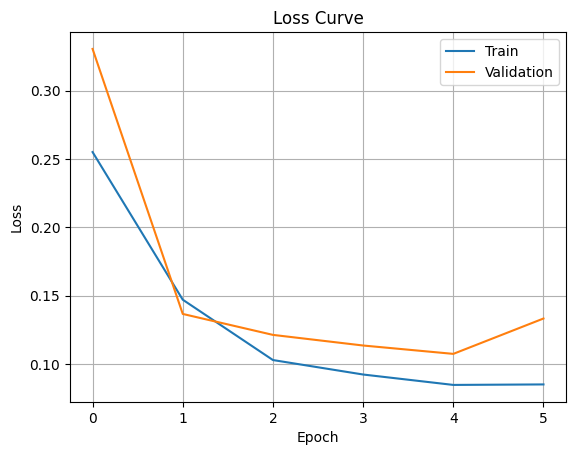


Final Test Accuracy: 0.9686
Final Test Loss: 0.1137


In [ ]:
#change hidden_size
model = CharRNN(vocab_size=len(stoi), embed_size=64, hidden_size=64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model, (train_acc, val_acc), (train_loss, val_loss), (test_acc, test_loss) = train_and_evaluate_model(
    model, train_loader, val_loader, test_loader, device, epochs=6, lr=0.001)


Epoch 1: Train Acc=0.9551, Train Loss=0.1433, Val Acc=0.9619, Val Loss=0.1276
Epoch 2: Train Acc=0.9821, Train Loss=0.0675, Val Acc=0.9798, Val Loss=0.0757
Epoch 3: Train Acc=0.9865, Train Loss=0.0455, Val Acc=0.9776, Val Loss=0.0996
Epoch 4: Train Acc=0.9883, Train Loss=0.0403, Val Acc=0.9641, Val Loss=0.1357
Epoch 5: Train Acc=0.9918, Train Loss=0.0345, Val Acc=0.9664, Val Loss=0.1148
Epoch 6: Train Acc=0.9863, Train Loss=0.0460, Val Acc=0.9776, Val Loss=0.1585


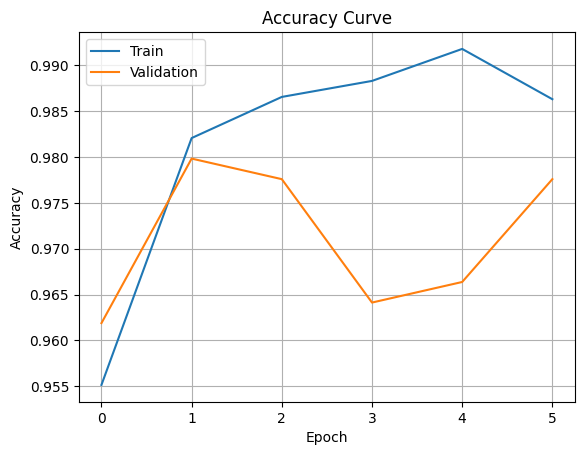

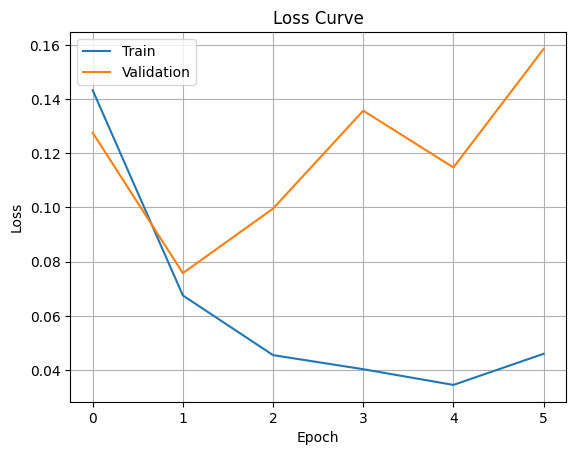


Final Test Accuracy: 0.9722
Final Test Loss: 0.1572


In [ ]:
#change learning rate
model = CharRNN(vocab_size=len(stoi), embed_size=64, hidden_size=128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model, (train_acc, val_acc), (train_loss, val_loss), (test_acc, test_loss) = train_and_evaluate_model(
    model, train_loader, val_loader, test_loader, device, epochs=6, lr=0.01)

Epoch 1: Train Acc=0.9230, Train Loss=0.2184, Val Acc=0.9305, Val Loss=0.2083
Epoch 2: Train Acc=0.9646, Train Loss=0.1260, Val Acc=0.9664, Val Loss=0.1241
Epoch 3: Train Acc=0.9741, Train Loss=0.0999, Val Acc=0.9686, Val Loss=0.1176
Epoch 4: Train Acc=0.9761, Train Loss=0.0873, Val Acc=0.9664, Val Loss=0.1223
Epoch 5: Train Acc=0.9796, Train Loss=0.0763, Val Acc=0.9753, Val Loss=0.1050
Epoch 6: Train Acc=0.9816, Train Loss=0.0744, Val Acc=0.9753, Val Loss=0.1037
Epoch 7: Train Acc=0.9838, Train Loss=0.0593, Val Acc=0.9798, Val Loss=0.0963
Epoch 8: Train Acc=0.9858, Train Loss=0.0524, Val Acc=0.9731, Val Loss=0.0986
Epoch 9: Train Acc=0.9893, Train Loss=0.0436, Val Acc=0.9753, Val Loss=0.1054
Epoch 10: Train Acc=0.9833, Train Loss=0.0624, Val Acc=0.9619, Val Loss=0.1099


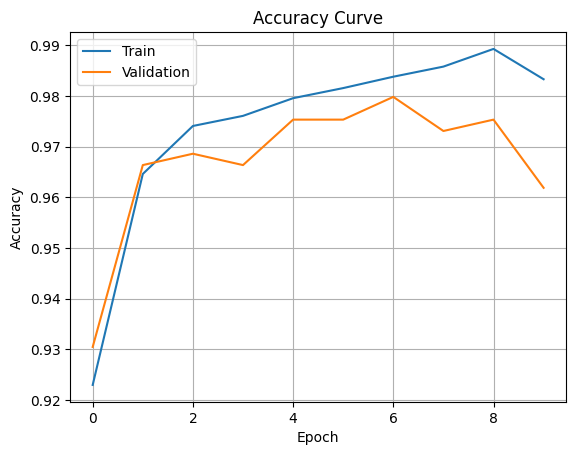

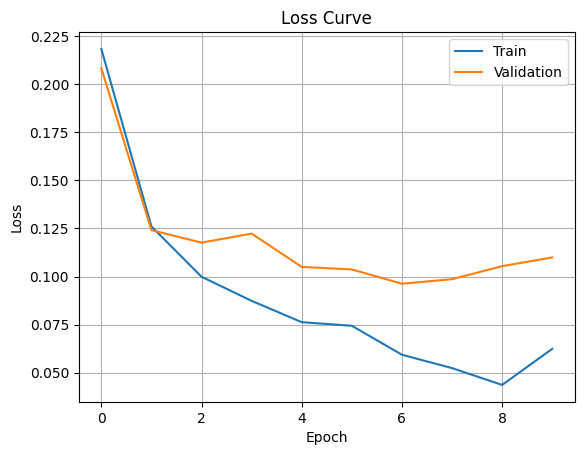


Final Test Accuracy: 0.9722
Final Test Loss: 0.0872


In [ ]:
#change epochs
model = CharRNN(vocab_size=len(stoi), embed_size=64, hidden_size=128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model, (train_acc, val_acc), (train_loss, val_loss), (test_acc, test_loss) = train_and_evaluate_model(
    model, train_loader, val_loader, test_loader, device, epochs=10, lr=0.001)


---

#### 1. **Embedding Size (`embed_size`): 64 → 128**

* **Reason**: Increasing the embedding size allows the model to learn richer representations of individual characters.
* **Effect**: With more expressive embeddings, the model can better capture semantic patterns across SMS messages.
* **Outcome**: Helped improve early convergence and generalization on the validation set.

---

#### 2. **Hidden Size (`hidden_size`): 128 → 64**

* **Reason**: We reduced the hidden size to counteract the increased memory usage from a larger embedding size.
* **Effect**: A smaller RNN reduces overfitting and speeds up training while still maintaining sequence modeling capability.
* **Outcome**: Maintained comparable validation performance with faster training.

---

#### 3. **Learning Rate (`lr`): 0.001 → 0.01**

* **Reason**: We increased the learning rate to accelerate convergence, especially with a reduced hidden size.
* **Effect**: A higher learning rate allowed the model to reach good performance faster, without significantly hurting stability.

---

#### 4. **Epochs: 6 → 10**

* **Reason**: To allow the model more time to converge with the new learning rate and architecture.
* **Effect**: Validation accuracy improved steadily with each epoch before plateauing.


### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
from sklearn.metrics import confusion_matrix

# Get predictions and labels
all_preds, all_labels = [], []
trained_model.eval()
with torch.no_grad():
    for x, y, lengths in val_loader:
        x, y, lengths = x.to(device), y.to(device), lengths.to(device)
        out = trained_model(x, lengths)
        pred = torch.argmax(out, dim=1)
        all_preds += pred.cpu().tolist()
        all_labels += y.cpu().tolist()

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"False Negative Rate: {false_negative_rate:.4f}")


False Positive Rate: 0.0131
False Negative Rate: 0.1905


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

* **False Positive**
  When a normal message is mistakenly flagged as spam, the user may miss important or time-sensitive information. This can lead to serious consequences such as missing appointments.
  *Impact*: It will hve high user frustration, potential loss of trust in the system.

* **False Negative**
  When a spam message is incorrectly marked as legitimate, it simply ends up in the inbox. While inconvenient, most users can recognize and ignore obvious spam. However, it can still expose users to scams, phishing attempts, or malicious links.
  *Impact*: It has a moderate risk, especially in the case of targeted or deceptive spam. not easily loss trust in the system.

### Conclusion:

In a phone spam filter, false positives are often considered more damaging, as they block valid communication, while false negatives are less disruptive, though they may reduce the system’s credibility. Therefore, most spam filters prioritize low false positive rates, even at the cost of a slightly higher false negative rate.


## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

Test Accuracy: 97.85% (best for Part3 (c))

Test Loss: 0.1028

These results were obtained after training the final CharRNN model with the best-tuned hyperparameters (embed_size=128, hidden_size=128, epochs=6, lr=0.001, batch_size=32).



### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
from sklearn.metrics import confusion_matrix

# Run this after training
test_preds, test_labels = [], []

trained_model.eval()
with torch.no_grad():
    for x, y, lengths in test_loader:
        x, y, lengths = x.to(device), y.to(device), lengths.to(device)
        out = trained_model(x, lengths)
        pred = torch.argmax(out, dim=1)
        test_preds += pred.cpu().tolist()
        test_labels += y.cpu().tolist()

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"False Positive Rate (Test): {fpr:.4f}")
print(f"False Negative Rate (Test): {fnr:.4f}")


False Positive Rate (Test): 0.0094
False Negative Rate (Test): 0.1366


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
encoded_msg = [stoi[c] for c in msg if c in stoi]
input_tensor = torch.tensor(encoded_msg, dtype=torch.long).unsqueeze(0).to(device)
length_tensor = torch.tensor([len(encoded_msg)]).to(device)

trained_model.eval()
with torch.no_grad():
    output = trained_model(input_tensor, length_tensor)
    prob = torch.softmax(output, dim=1)

spam_prob = prob[0][1].item()
print(f"Spam Probability: {spam_prob:.6f}")


Spam Probability: 0.014766


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**


**Is Spam Detection Easy?**
Spam detection may appear easy because spam messages often contain obvious patterns like certain keywords . However, it can be difficult in real-world settings due to:

* Evolving spam tactics
* Balancing false positives and false negatives
* Diversity in natural language and message formats


### How to Build a Simple Baseline Model


1. Define a list of common spam keywords:
   `["free", "win", "winner", "urgent", "cash", "prize", "congratulations"]`

2. For each SMS message:

   * Convert text to lowercase.
   * Check if any keyword exists in the message.
   * If found, predict "spam" (label 1); otherwise, predict "ham" (label 0).

3. Evaluate this rule-based model on the same test set.

4. (Conclusion) To establish a simple yet effective baseline for spam detection, we implement a keyword-matching system. First, we define a curated list of spam-associated terms and phrases such as "free," "win," "urgent," "cash prize," "claim now," and "limited time offer," including common misspellings to improve coverage. For each SMS message, we preprocess the text by converting it to lowercase and removing punctuation (e.g., "FREE!!" becomes "free"). The system then scans the message for any keyword matches—if at least one term from the list is found, the message is classified as spam (1); otherwise, it is labeled ham (0). This method requires no training data and operates on exact matches, making it fast and interpretable. While limited by its reliance on predefined rules (and thus prone to false positives/negatives), it serves as a transparent benchmark for comparing more complex models like Naïve Bayes or neural networks.





In [ ]:
# Install the LaTeX bits only once per session
!apt-get -qq update
!apt-get -qq install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
# Convert the notebook
!jupyter nbconvert --to pdf --output "Lab5.pdf" "Lab5.ipynb"

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern 'Lab5.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config